微调包括以下四个步骤。


在源数据集（例如ImageNet数据集）上预训练神经网络模型，即源模型。

创建一个新的神经网络模型，即目标模型。这将复制源模型上的所有模型设计及其参数（输出层除外）。我们假定这些模型参数包含从源数据集中学到的知识，这些知识也将适用于目标数据集。我们还假设源模型的输出层与源数据集的标签密切相关；因此不在目标模型中使用该层。

向目标模型添加输出层，其输出数是目标数据集中的类别数。然后随机初始化该层的模型参数。

在目标数据集（如椅子数据集）上训练目标模型。输出层将从头开始进行训练，而所有其他层的参数将根据源模型的参数进行微调。

In [1]:
%matplotlib inline
import os
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

获取数据集


我们使用的热狗数据集来源于网络。 该数据集包含1400张热狗的“正类”图像，以及包含尽可能多的其他食物的“负类”图像。 含着两个类别的1000张图片用于训练，其余的则用于测试。

解压下载的数据集，我们获得了两个文件夹hotdog/train和hotdog/test。 这两个文件夹都有hotdog（有热狗）和not-hotdog（无热狗）两个子文件夹， 子文件夹内都包含相应类的图像。

In [2]:
#获取数据集
d2l.DATA_HUB['hotdog'] = (d2l.DATA_URL + 'hotdog.zip',
                         'fba480ffa8aa7e0febbb511d181409f899b9baa5')

data_dir = d2l.download_extract('hotdog')

In [3]:
#创建两个实例来分别读取训练和测试数据集中的所有图像文件
train_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train'))
test_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'test'))

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

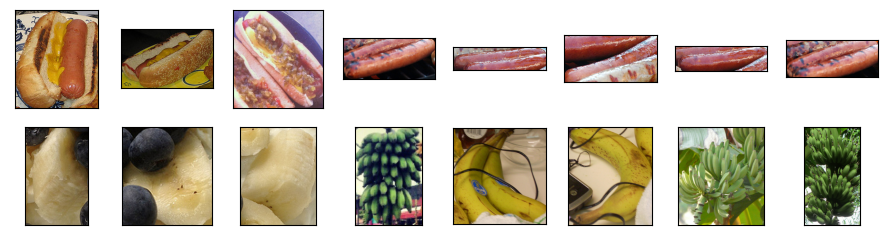

In [9]:
#显示了前8个正类样本图片和最后8张负类样本图片。正如所看到的，图像的大小和纵横比各有不同。
hotdogs = [train_imgs[i][0] for i in range(8)]
not_hotdogs = [train_imgs[-i - 1][0] for i in range(8)]
d2l.show_images(hotdogs + not_hotdogs, 2, 8, scale=1.4)

数据增广


在训练期间，我们首先从图像中裁切随机大小和随机长宽比的区域，然后将该区域缩放为224×224的输入图像。 在测试过程中，我们将图像的高度和宽度都缩放到256像素，然后裁剪中央224×224区域作为输入。 此外，对于RGB（红、绿和蓝）颜色通道，我们分别标准化每个通道。 具体而言，该通道的每个值减去该通道的平均值，然后将结果除以该通道的标准差。

In [10]:
# 对每个图像的RGB通道的均值和方差进行标准化，原因是Imagnet数据集中的图像进行了此操作。
normalize = torchvision.transforms.Normalize(
    [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(224),  #随机裁剪图像的224*224的一部分
    torchvision.transforms.RandomHorizontalFlip(),  #随机水平翻转增广
    torchvision.transforms.ToTensor(),
    normalize])

test_augs = torchvision.transforms.Compose([
    torchvision.transforms.Resize([256, 256]),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    normalize])

定义和初始化模型


我们使用在ImageNet数据集上预训练的ResNet-18作为源模型。 在这里，我们指定pretrained=True以自动下载预训练的模型参数。 如果首次使用此模型，则需要连接互联网才能下载。

In [11]:
pretrained_net = torchvision.models.resnet18(pretrained=True)

d:\python\conda\envs\d2l\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
d:\python\conda\envs\d2l\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\chenyilin/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100.0%


预训练的源模型实例包含许多特征层和一个输出层fc。 此划分的主要目的是促进对除输出层以外所有层的模型参数进行微调。 下面给出了源模型的成员变量fc。

In [12]:
#full connection全连接层
pretrained_net.fc

Linear(in_features=512, out_features=1000, bias=True)

In [14]:
#将预训练模型的特征提取部分提取出来，将最后一层全连接层进行修改，化为（输入=512，输出=2）的全连接层，然后对该层的权重进行随机初始化。
finetune_net = torchvision.models.resnet18(pretrained=True)
finetune_net.fc = nn.Linear(finetune_net.fc.in_features, 2)
nn.init.xavier_uniform_(finetune_net.fc.weight)

Parameter containing:
tensor([[ 0.0675,  0.0635,  0.0116,  ...,  0.0500, -0.0477, -0.0206],
        [ 0.0282, -0.0652,  0.0249,  ...,  0.0187,  0.0826,  0.0866]],
       requires_grad=True)

In [15]:
# 如果param_group=True，最后一层输出层中的模型参数将使用十倍的学习率，其余层均使用默认学习率
def train_fine_tuning(net, learning_rate, batch_size=128, num_epochs=5,
                      param_group=True):
    train_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'train'), transform=train_augs),
        batch_size=batch_size, shuffle=True)
    test_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'test'), transform=test_augs),
        batch_size=batch_size)
    devices = d2l.try_all_gpus()
    loss = nn.CrossEntropyLoss(reduction="none")
    if param_group:
        params_1x = [param for name, param in net.named_parameters()
             if name not in ["fc.weight", "fc.bias"]]
        trainer = torch.optim.SGD([{'params': params_1x},
                                   {'params': net.fc.parameters(),
                                    'lr': learning_rate * 10}],
                                lr=learning_rate, weight_decay=0.001)
    else:
        trainer = torch.optim.SGD(net.parameters(), lr=learning_rate,
                                  weight_decay=0.001)
    d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
                   devices)

loss 0.173, train acc 0.935, test acc 0.949
21.3 examples/sec on [device(type='cuda', index=0)]


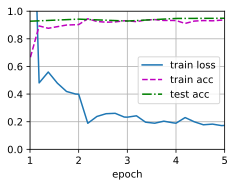

In [16]:
train_fine_tuning(finetune_net, 5e-5)

loss 0.355, train acc 0.849, test acc 0.839
21.7 examples/sec on [device(type='cuda', index=0)]


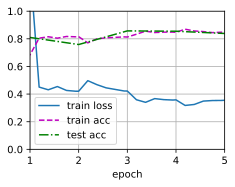

In [17]:
scratch_net = torchvision.models.resnet18()
scratch_net.fc = nn.Linear(scratch_net.fc.in_features, 2)
train_fine_tuning(scratch_net, 5e-4, param_group=False)